# Tree Edit Networks - VID RUN THIS

This notebook contains applications of graph edit networks (without edge actions) to trees.

In [31]:
import boolean_formulae
import peano_addition
from tqdm import tqdm
import pandas as pd
import seaborn as sns
lens = {3 : [], 4 : [], 5 : []}
bools3 = []
bools3_values = []
for l in range(3,6):
    print(f'now running for {l}')
    for i in tqdm(range(100000)):
        ts = boolean_formulae.generate_time_series(l)
        ll = len(ts)
        lens[l].append(ll )
        if ll>= 2:
            if ts[0] not in bools3:
                bools3.append(ts[0])
                bools3_values.append(ts)

df = pd.DataFrame(lens)
melted = pd.melt(df)
lens = {3 : [], 4 : [], 5 : []}

melted['kind'] = ['boolean'] * len(melted['variable'])
pean3 = []
pean3_values = []
for l in range(3,6):
    print(f'now running for {l}')
    for i in tqdm(range(100000)):
        ts = peano_addition.generate_time_series(l)
        ll = len(ts)
        lens[l].append(ll )
        if ll>= 2:
            if ts[0] not in pean3:
                pean3.append(ts[0])
                pean3_values.append(ts)

  1%|          | 636/100000 [00:00<00:15, 6357.11it/s]

now running for 3


  0%|          | 352/100000 [00:00<00:28, 3485.30it/s]

now running for 4


  0%|          | 296/100000 [00:00<01:06, 1509.50it/s]

now running for 5


  0%|          | 149/100000 [00:00<01:08, 1460.78it/s]

now running for 3


  0%|          | 71/100000 [00:00<02:20, 709.99it/s]

now running for 4


  0%|          | 31/100000 [00:00<05:45, 289.72it/s]

now running for 5


100%|██████████| 100000/100000 [06:39<00:00, 250.17it/s]


In [33]:

df = pd.DataFrame(lens)
melted2 = pd.melt(df)
melted2['kind'] = ['peano'] * len(melted2['variable'])

melted3 = pd.concat([melted, melted2])
melted3.to_csv('penosBooleans.csv', sep=',')

In [34]:
print(f'We were able to find {len(pean3)} Peano graphs, which is {len(pean3)*100/300000 :.2f}% of the sampled series')
print(f'We were able to find {len(bools3)} boolaen graphs, which is {len(bools3)*100/300000 :.2f}% of the sampled series')

We were able to find 77351 Peano graphs, which is 25.78% of the sampled series
We were able to find 38094 boolaen graphs, which is 12.70% of the sampled series


In [36]:
import pickle
with open('results_temp/bool_timseries.pkl', 'wb') as f:
    pickle.dump(bools3_values, f)

with open('results_temp/peano_timseries.pkl', 'wb') as f:
    pickle.dump(pean3_values, f)



MARUŠA RUN THIS

In [38]:
with open('results_temp/bool_timseries.pkl', 'rb') as f:
    ALL_BOOLS = pickle.load(f)

with open('results_temp/peano_timseries.pkl', 'rb') as f:
    ALL_PEANOS = pickle.load(f)

print(len(ALL_BOOLS))

38094


## Task 1: Boolean Formula Simplification

We generate a random Boolean formula over the variables $x$ and $y$ with at most 3 binary operators and then apply simplification rules until none apply anymore. The time series is the series of iteratively simpler formulae.

In [4]:
# set up the model
import torch
import numpy as np
import pytorch_tree_edit_networks as ten

# the number of experimental repititions
R = 5
# the number of test trees
N_test = 10

# training hyperparameters
max_epochs     = 12
learning_rate  = 1E-3
weight_decay   = 1E-5
loss_threshold = 1E-3

# model hyperparameters
num_layers = 2
dim_hid = 64
skip_connections = False
nonlin = torch.nn.ReLU()
max_degree = 4

accs = np.zeros(R)
learning_curves = []

In [6]:
# learn
import edist.tree_utils as tu
import boolean_formulae

unique = True

for r in range(R):
    print('--- repeat %d of %d ---' % (r+1, R))
    test_set, unique_As = boolean_formulae.create_test_set(N_test)
    # instantiate network and optimizer
    net = ten.TEN(num_layers = num_layers, alphabet = boolean_formulae.alphabet,
                  dim_hid = dim_hid, skip_connections = skip_connections, nonlin = nonlin,
                  dim_in_extra = max_degree + 1)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # start training
    loss_avg = None
    learning_curve = []
    epochs = 0
    while epochs < max_epochs:
        optimizer.zero_grad()
        # sample a nontrivial time series
        if unique:
            time_series = boolean_formulae.generate_unique_time_series(test_set)
        else:
            time_series = boolean_formulae.generate_time_series()
        if len(time_series) < 2:
            continue
        # compute the prediction loss
        loss = boolean_formulae.compute_loss(net, time_series)
        # compute the gradient
        loss.backward()
        # perform an optimizer step
        optimizer.step()
        # compute a new moving average over the loss
        if loss_avg is None:
            loss_avg = loss.item()
        else:
            loss_avg = loss_avg * 0.9 + 0.1 * loss.item()
        learning_curve.append(loss.item())
        if((epochs+1) % 10 == 0):
            #print('loss avg after %d epochs: %g' % (epochs+1, loss_avg))
        epochs += 1
        if loss_avg < loss_threshold:
            break

    #print('stopped training')
    #learning_curves.append(learning_curve)
    # after training is completed, evaluate
    j = 0
    T = 0
    while j < N_test:
        #print('at the top of while')
        # sample a random time series
        if unique:
            time_series = test_set[j]
        else:
            time_series = boolean_formulae.generate_time_series()
        if len(time_series) < 2:
            continue
        # iterate over the time series
        #print(len(time_series))
        for t in range(len(time_series)-1):
            #print(t)
            # perform the prediction
            nodes, adj = time_series[t]
            try:
                _, nodes_actual, adj_actual = boolean_formulae.predict_step(net, nodes, adj)
                nodes_expected, adj_expected = time_series[t+1]
                if nodes_actual == nodes_expected and adj_actual == adj_expected:
                    accs[r] += 1
                else:
                    #print('expected tree %s but was actually %s' % (tu.tree_to_string(nodes_expected, adj_expected), tu.tree_to_string(nodes_actual, adj_actual)))
            except Exception as ex:
                try:
                    #print('handling exception 1')
                    boolean_formulae.predict_step(net, nodes, adj, verbose = True)
                except Exception as ex2:
                    #print('handling exception 1')
                    pass
                #print('Exception for input tree %s and network output %s\nexception was %s' % (tu.tree_to_string(nodes, adj, indent = True, with_indices = True), deltaX, str(ex)))


        print('managed to exit!')
        T += len(time_series)-1
        j += 1
        print('at the bottom of while')
    accs[r] /= T
    print('accuracy: %g' % accs[r])

--- repeat 1 of 5 ---
loss avg after 10 epochs: 16.3223
stopped training
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
accuracy: nan
--- repeat 2 of 5 ---


<ipython-input-6-7af074ae8870>:88: RuntimeWarning: invalid value encountered in double_scalars
  accs[r] /= T


loss avg after 10 epochs: 20.52
stopped training
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
accuracy: nan
--- repeat 3 of 5 ---
loss avg after 10 epochs: 18.6273
stopped training
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
accuracy: nan
--- repeat 4 of 5 ---
loss avg after 10 epochs: 16.7399
stopped training
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
at the top of while
accuracy: nan
--- repeat 5 of 5 ---


KeyboardInterrupt: 

In [ ]:
# print results
print('Accuracy: %g +- %g' % (np.mean(accs), np.std(accs)))
num_epochs = np.array(list(map(len, learning_curves)))
print('Epochs: %g +- %g' % (np.mean(num_epochs), np.std(num_epochs)))

In [ ]:
# visualize learning curves
import matplotlib.pyplot as plt
smoothing_steps = 10
for r in range(R):
    # compute a moving average before visualization
    acum = np.cumsum(learning_curves[r])
    plt.semilogy((acum[smoothing_steps:] - acum[:-smoothing_steps])/smoothing_steps)
plt.show()

## Task 2: Addition

We generate an addition formula of at most four numbers in the range 1-3 and then use the Peano addition axiom to compute the addition. In particular, the following four rules apply.

1. +(m, 0) for any m can be replaced with m.
2. +(m, succ(n)) can be replaced with succ(+(m, n)).
3. +(m, n) for n in the range 0-9 can be replaced with +(m, succ(n-1)) where -1 refers to the numeric subtraction of 1.
4. succ(n) for n in the range 0-9 can be replaced with n+1 (mod 10 because we don't permit two-digit numbers).

A time series arises by applying to a current tree every rule that is applicable until a tree results which is only a single number.

In [6]:
# set up the model
import torch
import numpy as np
import pytorch_tree_edit_networks as ten

# the number of experimental repititions
R = 5
# the number of test trees
N_test = 10

# training hyperparameters
max_epochs     = 30000
learning_rate  = 1E-3
weight_decay   = 1E-5
loss_threshold = 1E-3

# model hyperparameters
# a single layer with sufficient neurons should suffice here, because we only need to
# check immediate parents and children to check whether a rule applies
num_layers = 2
dim_hid = 64
skip_connections = False
nonlin = torch.nn.ReLU()
max_degree = 2

accs = np.zeros(R)
learning_curves = []

In [8]:
# learn
unique = True
import edist.tree_utils as tu
import peano_addition

for r in range(R):
    print('--- repeat %d of %d ---' % (r+1, R))
    test_set, unique_As = peano_addition.create_test_set(N_test)
    # instantiate network and optimizer
    net = ten.TEN(num_layers = num_layers, alphabet = peano_addition.alphabet,
                  dim_hid = dim_hid, skip_connections = skip_connections, nonlin = nonlin,
                  dim_in_extra = max_degree + 1)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # start training
    loss_avg = None
    learning_curve = []
    epochs = 0
    while epochs < max_epochs:
        optimizer.zero_grad()
        # sample a nontrivial time series
        if unique:
            time_series = peano_addition.generate_unique_time_series(test_set)
        else:
            time_series = peano_addition.generate_time_series()
        if len(time_series) < 2:
            continue
        # compute the prediction loss
        loss = peano_addition.compute_loss(net, time_series)
        # compute the gradient
        loss.backward()
        # perform an optimizer step
        optimizer.step()
        # compute a new moving average over the loss
        if loss_avg is None:
            loss_avg = loss.item()
        else:
            loss_avg = loss_avg * 0.9 + 0.1 * loss.item()
        learning_curve.append(loss.item())
        if((epochs+1) % 100 == 0):
            print('loss avg after %d epochs: %g' % (epochs+1, loss_avg))
        epochs += 1
        if loss_avg < loss_threshold:
            break
    learning_curves.append(learning_curve)
    # after training is completed, evaluate
    j = 0
    T = 0
    while j < N_test:
        # sample a random time series
        if unique:
            time_series = test_set[j]
        else:
            time_series = peano_addition.generate_time_series()
        if len(time_series) < 2:
            continue
        # iterate over the time series
        for t in range(len(time_series)-1):
            # perform the prediction
            nodes, adj = time_series[t]
            try:
                _, nodes_actual, adj_actual = peano_addition.predict_step(net, nodes, adj)
                nodes_expected, adj_expected = time_series[t+1]
                if nodes_actual == nodes_expected and adj_actual == adj_expected:
                    accs[r] += 1
                else:
                    print('expected tree %s but was actually %s' % (tu.tree_to_string(nodes_expected, adj_expected), tu.tree_to_string(nodes_actual, adj_actual)))
            except Exception as ex:
                try:
                    peano_addition.predict_step(net, nodes, adj, verbose = True)
                except Exception as ex2:
                    pass
                print('Exception for input tree %s and network output %s\nexception was %s' % (tu.tree_to_string(nodes, adj, indent = True, with_indices = True), deltaX, str(ex)))
        T += len(time_series)-1
        j += 1
    accs[r] /= T
    print('accuracy: %g' % accs[r])

--- repeat 1 of 5 ---


KeyboardInterrupt: 

In [ ]:
# print results
print('Accuracy: %g +- %g' % (np.mean(accs), np.std(accs)))
num_epochs = np.array(list(map(len, learning_curves)))
print('Epochs: %g +- %g' % (np.mean(num_epochs), np.std(num_epochs)))

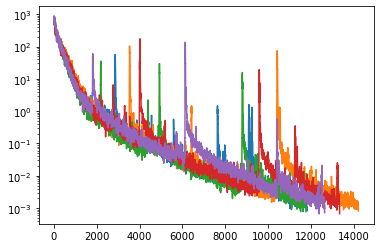

In [4]:
# visualize learning curves
import matplotlib.pyplot as plt
smoothing_steps = 10
for r in range(R):
    # compute a moving average before visualization
    acum = np.cumsum(learning_curves[r])
    plt.semilogy((acum[smoothing_steps:] - acum[:-smoothing_steps])/smoothing_steps)
plt.show()